# Практическое задание к уроку "Сегментация"

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Можете взять один из этих наборов данных:
- https://www.kaggle.com/carlolepelaars/camvid
- https://www.kaggle.com/dansbecker/cityscapes-image-pairs
- https://www.kaggle.com/tapakah68/segmentation-full-body-mads-dataset
- https://www.kaggle.com/longnguyen2306/bacteria-detection-with-darkfield-microscopy
- https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels
2. Опишите в комментарии - какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

Выбран датасет: https://www.kaggle.com/dansbecker/cityscapes-image-pairs

In [1]:
import numpy as np

In [2]:
from pathlib import Path
from keras.preprocessing import image

path_train = './data/cityscapes_data/train/'
path_validation = './data/cityscapes_data/val/'

train_images_paths = list(Path(path_train).iterdir())
validation_images_paths = list(Path(path_validation).iterdir())

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
single_image = image.load_img(train_images_paths[0])
image_size = (int(single_image.size[0]/2), single_image.size[1])
image_size

(256, 256)

In [4]:
def load_images_with_masks(paths):
    images = []
    masks = []

    for path in train_images_paths:
        temp_img = image.load_img(path) 
        img = temp_img.crop((0, 0, image_size[0], image_size[1])) 
        mask = temp_img.crop((image_size[0], 0, image_size[0] * 2, image_size[1]))
        images.append(img)
        masks.append(mask)

    return images, masks

images, masks = load_images_with_masks(train_images_paths)

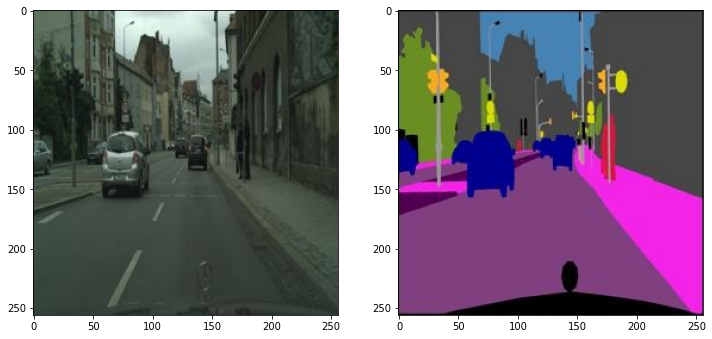

In [5]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(images[80].convert('RGBA'))
ax[1].imshow(masks[80].convert('RGBA'))

In [6]:
def extract_classes_from_masks(masks, gradations_number=3):
    classes = set()
    max_color_value = 255
    color_group_divider = int(max_color_value / gradations_number) 

    for mask in masks:
        for pixel in masks[0].convert('RGBA').getdata():
            r = int(pixel[0] / color_group_divider) * color_group_divider
            g = int(pixel[1] / color_group_divider) * color_group_divider
            b = int(pixel[2] / color_group_divider) * color_group_divider
            classes.add((r, g, b,))

    return [[item[0], item[1], item[2]] for item in list(classes)]


In [7]:
classes = extract_classes_from_masks(masks, 3)

In [8]:
def get_X_from_images(images):
    X = []

    for img in images:
        x = image.img_to_array(img)
        X.append(x)

    X = np.array(X)

    return X

In [9]:
X = get_X_from_images(images)

In [10]:
def Color2index(y, classes):
    y_ind = np.zeros((y.shape[0], y.shape[1]))
    y_cat = np.zeros((y.shape[0], y.shape[1], len(classes)))
    i = 1
    for color in classes:
        ind_i = np.where(
            (y[..., 0] >= color[0]) & (y[..., 0] <= color[0] + 85) 
            & (y[..., 1] >= color[1]) & (y[..., 1] <= color[1] + 85)
            & (y[..., 2] >= color[2]) & (y[..., 2] <= color[2] + 85)
        )
        y_ind[ind_i[0], ind_i[1]] = i
        y_cat[ind_i[0], ind_i[1], i-1] = 1 
        i += 1
    
    return y_cat, y_ind

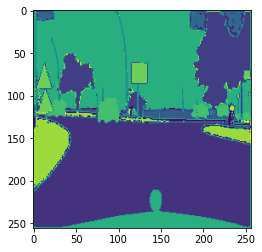

In [11]:
from keras.preprocessing import image
cat_yi, ind_yi = Color2index(image.img_to_array(masks[0]), classes)

plt.imshow(ind_yi)
plt.show()  

In [12]:
ind_yi

array([[18., 18., 18., ..., 18., 18., 18.],
       [18.,  4., 14., ..., 27., 27., 18.],
       [18., 14., 19., ...,  6.,  6., 18.],
       ...,
       [18.,  5.,  5., ...,  5.,  5., 18.],
       [18., 18., 18., ..., 18., 18., 18.],
       [18., 18., 18., ..., 18., 18., 18.]])

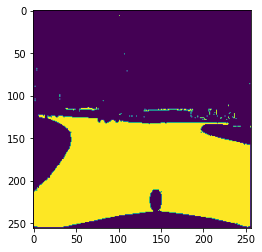

In [13]:
plt.imshow(cat_yi[..., 4])
plt.show()

In [14]:
cat_yi.shape

(256, 256, 28)

In [15]:
def get_target_from_masks(masks):
  y = []

  for mask in masks[0:500]:
    y_cat, y_in = Color2index(image.img_to_array(mask), classes)
    y.append(y_cat)

  y = np.array(y)

  return y

In [21]:
y = get_target_from_masks(masks)

In [22]:
classes

[[85, 0, 0],
 [170, 170, 170],
 [170, 0, 85],
 [0, 85, 85],
 [85, 0, 85],
 [85, 85, 0],
 [170, 85, 0],
 [85, 0, 170],
 [170, 0, 170],
 [0, 85, 170],
 [85, 255, 85],
 [170, 255, 85],
 [170, 85, 85],
 [85, 85, 85],
 [85, 255, 170],
 [170, 255, 170],
 [170, 85, 170],
 [0, 0, 0],
 [85, 85, 170],
 [0, 0, 85],
 [85, 170, 0],
 [170, 170, 0],
 [0, 0, 170],
 [85, 170, 85],
 [170, 170, 85],
 [170, 0, 0],
 [0, 85, 0],
 [85, 170, 170]]

In [23]:
y.shape

(500, 256, 256, 28)

In [24]:
y[0]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

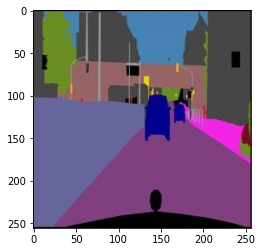

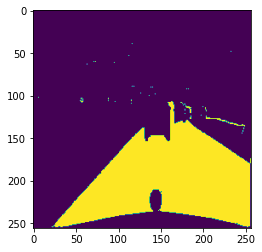

In [25]:
n = 4
plt.imshow(masks[n].convert('RGBA'))
plt.show()
img = y[n][..., 4]

plt.imshow(img)
plt.show()

In [26]:
N = 300
y_train = y[:N, ...]
X_train = X[:N, ...]

y_test = y[N:, ...]
X_test = X[N:, ...]

In [27]:
y_test.shape

(200, 256, 256, 28)

In [28]:
print(X_train.shape)
print(y_train.shape)

(300, 256, 256, 3)
(300, 256, 256, 28)


In [29]:
from keras.models import Model
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization, 
                          Conv2D, Conv2DTranspose, concatenate)
from tensorflow.keras.utils import plot_model

def Unet(num_classes=28, input_shape=(256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)


    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)


    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)


    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

 
    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

In [30]:
import keras.backend as K

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

In [31]:
import keras
from IPython.display import clear_output


def show_predictions(model):
    pred_mask = model.predict(sample_image[None])[..., 0]
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image / 255.0)
    ax[1].imshow(sample_mask[..., 0])
    ax[2].imshow(np.squeeze(pred_mask, axis=0))
    plt.show()


class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience
    
    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            clear_output(wait=True)
            show_predictions(self.model)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

In [32]:
import tensorflow
from tensorflow.keras.optimizers import Adam

model = Unet()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [33]:
X_train[0], y_train[0]

(array([[[180., 207., 202.],
         [177., 204., 199.],
         [124., 151., 146.],
         ...,
         [ 27.,  43.,  33.],
         [ 34.,  52.,  40.],
         [ 25.,  40.,  33.]],
 
        [[179., 206., 201.],
         [177., 204., 199.],
         [124., 151., 146.],
         ...,
         [ 54.,  70.,  60.],
         [ 26.,  44.,  32.],
         [ 46.,  63.,  57.]],
 
        [[176., 205., 201.],
         [175., 204., 200.],
         [123., 152., 148.],
         ...,
         [ 33.,  49.,  39.],
         [ 20.,  38.,  26.],
         [ 35.,  56.,  51.]],
 
        ...,
 
        [[ 84., 103.,  84.],
         [ 84., 103.,  84.],
         [ 84., 103.,  84.],
         ...,
         [ 55.,  71.,  61.],
         [ 55.,  71.,  61.],
         [ 64.,  65.,  67.]],
 
        [[ 82., 101.,  82.],
         [ 83., 102.,  83.],
         [ 83., 102.,  83.],
         ...,
         [ 55.,  71.,  61.],
         [ 55.,  71.,  61.],
         [ 62.,  66.,  65.]],
 
        [[ 81., 100.,  81.],
 

In [34]:
print(X_test.shape)
print(y_test.shape)

(2675, 256, 256, 3)
(200, 256, 256, 28)


In [35]:
# fit_limit = {
#     'train': 400,
#     'test': 100
# }
# history = model.fit(
#     X_train[0:fit_limit['train']], 
#     y_train[0:fit_limit['train']],
#     epochs=3,
#     batch_size=1,
#     validation_data=(X_test[0:fit_limit['test']], y_test[0:fit_limit['test']]),
#     callbacks=[DisplayCallback(patience=5)]
# )

In [36]:
MODEL_WEIGHTS_PATH = 'model_weights.h5'

In [37]:
# model.save_weights(MODEL_WEIGHTS_PATH)

In [38]:
model.load_weights(MODEL_WEIGHTS_PATH)

In [39]:
val_images, val_masks = load_images_with_masks(validation_images_paths)

In [40]:
X_val = get_X_from_images(val_images)

In [41]:
y_val = get_target_from_masks(val_masks)

In [42]:
pred = model.predict(X_val[0:50])
print(pred.shape)

(50, 256, 256, 28)


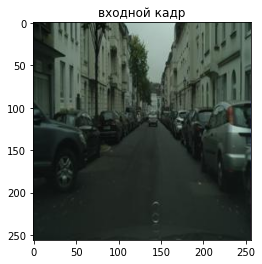

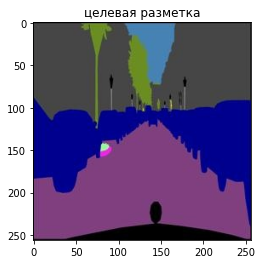

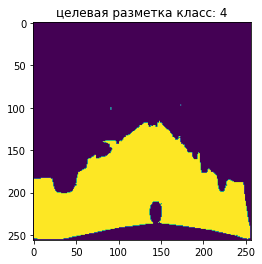

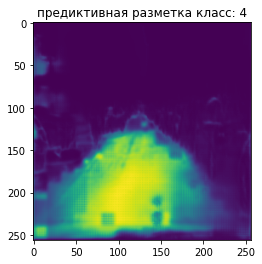

In [44]:
n = 11
class_ = 4
plt.imshow(val_images[n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(val_masks[n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()

img = y_val[n][..., class_]
plt.imshow(img)
plt.title('целевая разметка класс: ' + str(class_))
plt.show()
img = pred[n - 1][..., class_]
plt.imshow(img)
plt.title('предиктивная разметка класс: ' + str(class_))
plt.show()

Удалось обучить нейронную сеть различать размеченные классы на фотографиях.

На последнем изображении продемонстрировано определение класса дороги. 

Обучение требовало значительных системных ресурсов. В частности столкнулся с нехваткой оперативной памяти, в связи с чем пришлось уменьшать количество эпох до 3.

Как вариант для решения проблемы можно использовать предобученные сети (VGG16) или дообучить имеющуюся модель.